Trying to fetch data with Alpaca SDK...
Alpaca fetch failed (alpaca-py SDK not available or import failed). Falling back to yfinance.
Fetched 1014 rows from yfinance.
After feature engineering rows: 994
Shapes: (772, 30, 6) (772, 1) (192, 30, 6) (192, 1)


/tmp/ipython-input-3276856553.py:91: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, progress=False)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 30, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,625 (307.13 KB)

 Trainable params: 78,625 (307.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


25/25 - 4s - 160ms/step - loss: 0.0207 - mae: 0.0925 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 2/50
25/25 - 0s - 14ms/step - loss: 0.0026 - mae: 0.0353 - val_loss: 0.0125 - val_mae: 0.1032
Epoch 3/50
25/25 - 0s - 14ms/step - loss: 0.0023 - mae: 0.0325 - val_loss: 0.0085 - val_mae: 0.0835
Epoch 4/50
25/25 - 0s - 14ms/step - loss: 0.0022 - mae: 0.0307 - val_loss: 0.0095 - val_mae: 0.0887
Epoch 5/50
25/25 - 0s - 14ms/step - loss: 0.0018 - mae: 0.0289 - val_loss: 0.0066 - val_mae: 0.0729
Epoch 6/50
25/25 - 0s - 14ms/step - loss: 0.0022 - mae: 0.0323 - val_loss: 0.0114 - val_mae: 0.0973
Epoch 7/50
25/25 - 0s - 14ms/step - loss: 0.0019 - mae: 0.0298 - val_loss: 0.0141 - val_mae: 0.1095
Epoch 8/50
25/25 - 0s - 14ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 0.0112 - val_mae: 0.0964
Epoch 9/50
25/25 - 0s - 14ms/step - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0054 - val_mae: 0.0635
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Test MAE: 6.9718 USD


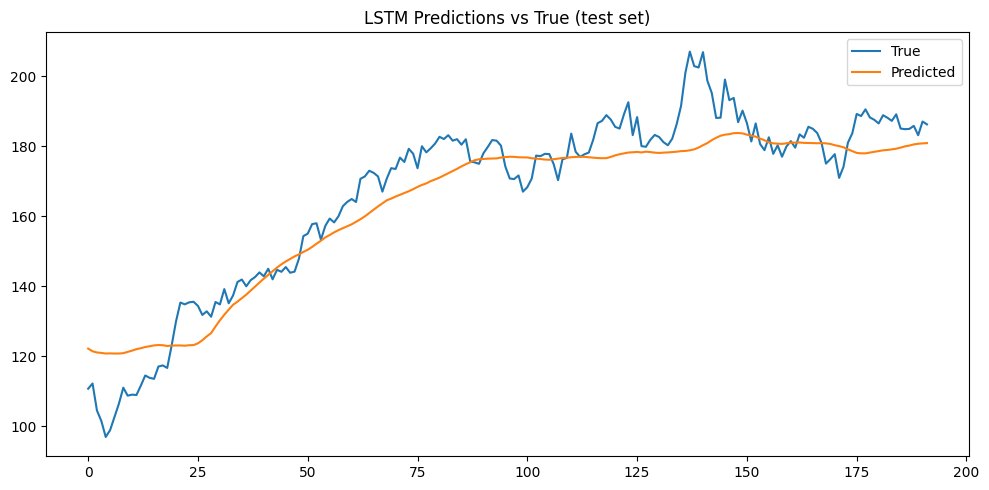

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Last close (most recent): 187.05
Model next-day predicted close: 180.95


/tmp/ipython-input-3276856553.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_close = float(df['close'].values[-1])


In [3]:
#!/usr/bin/env python3
"""
nvda_lstm_pipeline.py

Full pipeline:
- Pull historical daily bars for NVDA (Alpaca SDK if available, else yfinance fallback)
- Feature engineering (close, volume, volatility, ma_5, ma_10, ma_20)
- Build time-series sequences for LSTM
- Train Keras LSTM model
- Evaluate and produce next-day prediction
Requirements:
  pip install pandas numpy scikit-learn tensorflow matplotlib alpaca-py yfinance
(Alpaca is optional; if not available we use yfinance.)
"""

import os
import math
import datetime as dt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ---- Config ----
SYMBOL = "NVDA"
START_DATE = "2022-01-01"
END_DATE = dt.date.today().isoformat()
TIMEFRAME = "1Day"  # daily
SEQUENCE_LENGTH = 30  # days of history used to predict next day
TEST_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 50
MODEL_SAVE_PATH = "nvda_lstm.h5"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# ---- Data retrieval: Alpaca if available, else yfinance ----
def fetch_with_alpaca(symbol, start, end):
    try:
        # Attempt to import the new alpaca-py SDK names used in your screenshot
        from alpaca.data import StockHistoricalDataClient
        from alpaca.data.requests import StockBarsRequest
        from alpaca.data.timeframe import TimeFrame
    except Exception as e:
        raise RuntimeError("alpaca-py SDK not available or import failed") from e

    API_KEY = os.getenv("APCA_API_KEY_ID") or os.getenv("ALPACA_API_KEY")
    API_SECRET = os.getenv("APCA_API_SECRET_KEY") or os.getenv("ALPACA_API_SECRET")
    if not API_KEY or not API_SECRET:
        raise RuntimeError("Alpaca keys not found in environment. Set APCA_API_KEY_ID and APCA_API_SECRET_KEY.")

    client = StockHistoricalDataClient(API_KEY, API_SECRET)

    request_params = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=TimeFrame.Day,
        start=start,
        end=end,
    )

    bars = client.get_stock_bars(request_params)
    df = bars.df.reset_index()  # alpaca returns a multiindex if multiple symbols
    # If symbol returned as column level, handle accordingly:
    # Some alpaca versions return columns like ("NVDA", "close"). Extract NVDA slice if needed.
    if isinstance(df.columns, pd.MultiIndex):
        # select columns for the symbol
        if symbol in df.columns.get_level_values(0):
            df = df[symbol].reset_index()
    df = df.rename(columns={col: col.lower() for col in df.columns})
    # ensure necessary columns: timestamp, open, high, low, close, volume
    # keep date index
    if 'timestamp' in df.columns:
        df = df.rename(columns={'timestamp': 'date'})
    if 'index' in df.columns:
        df = df.rename(columns={'index': 'date'})
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date']).dt.date
    return df

def fetch_with_yfinance(symbol, start, end):
    import yfinance as yf
    df = yf.download(symbol, start=start, end=end, progress=False)
    df = df.reset_index()
    df = df.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Volume": "volume", "Adj Close": "adj_close"})
    df['date'] = pd.to_datetime(df['date']).dt.date
    # keep required columns
    return df[['date', 'open', 'high', 'low', 'close', 'volume']]

def get_data(symbol=SYMBOL, start=START_DATE, end=END_DATE):
    # Try Alpaca first
    try:
        print("Trying to fetch data with Alpaca SDK...")
        df = fetch_with_alpaca(symbol, start, end)
        print(f"Fetched {len(df)} rows from Alpaca.")
        return df
    except Exception as e:
        print(f"Alpaca fetch failed ({e}). Falling back to yfinance.")
        df = fetch_with_yfinance(symbol, start, end)
        print(f"Fetched {len(df)} rows from yfinance.")
        return df

# ---- Feature engineering ----
def engineer_features(df):
    # Sort by date
    df = df.sort_values("date").reset_index(drop=True)
    # rolling volatility: std of daily returns over 5 days
    df['return'] = df['close'].pct_change()
    df['volatility'] = df['return'].rolling(5).std()
    # moving averages
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['ma_20'] = df['close'].rolling(20).mean()
    # target = next day's close
    df['target'] = df['close'].shift(-1)
    # drop rows with NaNs (from rolling windows or last row because of shift)
    df = df.dropna().reset_index(drop=True)
    # select features we will use
    features = ['close', 'volume', 'volatility', 'ma_5', 'ma_10', 'ma_20']
    return df, features

# ---- Prepare sequences for LSTM ----
def create_sequences(df, feature_cols, seq_length=SEQUENCE_LENGTH):
    data = df[feature_cols].values
    targets = df['target'].values.reshape(-1, 1)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    data_scaled = scaler_X.fit_transform(data)
    targets_scaled = scaler_y.fit_transform(targets)

    X = []
    y = []
    for i in range(seq_length, len(data_scaled)):
        X.append(data_scaled[i-seq_length:i, :])
        y.append(targets_scaled[i, 0])
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    return X, y, scaler_X, scaler_y

# ---- Train/test split ----
def split_train_test(X, y, test_fraction=TEST_SPLIT):
    n = len(X)
    test_size = int(n * test_fraction)
    train_X = X[:-test_size]
    train_y = y[:-test_size]
    test_X = X[-test_size:]
    test_y = y[-test_size:]
    return train_X, train_y, test_X, test_y

# ---- Build LSTM model ----
def build_lstm_model(input_shape):
    model = Sequential()
    # Bidirectional LSTM can help; you can simplify to LSTM if preferred
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.15))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))  # regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ---- Run pipeline ----
def run_pipeline():
    df_raw = get_data()
    if df_raw is None or len(df_raw) < SEQUENCE_LENGTH + 10:
        raise RuntimeError("Not enough data to train. Increase date range or fix data source.")

    df, feature_cols = engineer_features(df_raw)
    print(f"After feature engineering rows: {len(df)}")
    X, y, scaler_X, scaler_y = create_sequences(df, feature_cols, seq_length=SEQUENCE_LENGTH)
    train_X, train_y, test_X, test_y = split_train_test(X, y, TEST_SPLIT)

    print("Shapes:", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # Build model
    model = build_lstm_model(input_shape=(train_X.shape[1], train_X.shape[2]))
    model.summary()

    # Callbacks
    early = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

    history = model.fit(
        train_X, train_y,
        validation_data=(test_X, test_y),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early, checkpoint],
        verbose=2
    )

    # Evaluate
    preds_scaled = model.predict(test_X)
    preds = scaler_y.inverse_transform(preds_scaled)
    y_true = scaler_y.inverse_transform(test_y)

    mae = mean_absolute_error(y_true, preds)
    print(f"Test MAE: {mae:.4f} USD")

    # Plot predictions vs true
    plt.figure(figsize=(10,5))
    plt.plot(y_true.flatten(), label="True")
    plt.plot(preds.flatten(), label="Predicted")
    plt.title("LSTM Predictions vs True (test set)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Predict next day
    last_seq_raw = df[feature_cols].values[-SEQUENCE_LENGTH:]
    last_seq_scaled = scaler_X.transform(last_seq_raw)
    input_seq = np.expand_dims(last_seq_scaled, axis=0)  # shape (1, seq_len, n_features)
    next_pred_scaled = model.predict(input_seq)          # shape (1, 1) or (1,)
    # convert back to original scale and get scalar float
    next_pred_array = scaler_y.inverse_transform(next_pred_scaled.reshape(-1, 1))
    next_pred = float(next_pred_array[0, 0])             # now a Python float

    last_close = float(df['close'].values[-1])
    print(f"Last close (most recent): {last_close:.2f}")
    print(f"Model next-day predicted close: {next_pred:.2f}")

    return {
        "model": model,
        "scaler_X": scaler_X,
        "scaler_y": scaler_y,
        "df": df,
        "history": history,
        "test_true": y_true,
        "test_pred": preds,
        "next_pred": next_pred
    }

if __name__ == "__main__":
    results = run_pipeline()
